In [1]:
import json
import os
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in `{models_path}/{run_num}/metrics.json` and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def import_all_metrics_json(models_path):
    """
    Looks in `models_path` and finds all instances of
    `{models_path}/{run_num}/metrics.json`, returning a dictionary that maps
    `{run_num}` to the metrics dictionary.
    """
    all_metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    all_metrics = {key : val for key, val in all_metrics.items() if val}  # Remove empties
    return all_metrics

In [ ]:
def extract_metrics_losses(metrics, key):
    """
    From a single metrics dictionary (i.e. the imported metrics.json for a
    single run), extracts the list of epoch-level losses with the given key.
    """
    assert key in (
        "train_att_losses", "train_corr_losses", "train_epoch_loss",
        "val_att_losses", "val_corr_losses", "val_epoch_loss",
    )
    return metrics[key]["values"]  # A single list

In [ ]:
def extract_metrics_batch_losses(metrics, key):
    """
    From a single metrics dictionary (i.e. the imported metrics.json for a
    single run), extracts the batch-level losses with the given key, as a
    list of lists (each outer list is an epoch, each inner list is the
    batch losses).
    """
    assert key in (
        "train_batch_losses", "val_batch_losses"
    )
    return metrics[key]["values"]  # A list of lists

In [25]:
def extract_metrics_values(metrics, key):
    """
    From a single metrics dictionary (i.e. the imported metrics.json for a
    single run), extracts the set of values with the given key.
    """
    return metrics[key]["values"]

In [5]:
def smooth_signal(signal, sigma, axis=-1):
    """
    Smooths a signal along the given axis using a Gaussian weight vector.
    Smooths to 1 sigma (unless sigma is 0, and then it does no smoothing).
    """
    if sigma == 0:
        return scipy.ndimage.gaussian_filter1d(signal, 1, axis=axis, truncate=0)
    else:
        return scipy.ndimage.gaussian_filter1d(signal, sigma, axis=axis, truncate=1)

In [20]:
noprior_models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_overfit/"
prior_models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_prior_overfit/"
noprior_noisy_models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_noise100_overfit/"
prior_noisy_models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_prior_noise100_overfit/"

noprior_metrics = import_all_metrics_json(noprior_models_path)
prior_metrics = import_all_metrics_json(prior_models_path)
noprior_noisy_metrics = import_all_metrics_json(noprior_noisy_models_path)
prior_noisy_metrics = import_all_metrics_json(prior_noisy_models_path)

Text(0.5, 1.0, 'Validation epoch losses with and without prior')

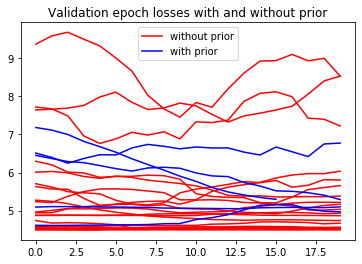

In [7]:
# Plot validation epoch losses with and without prior
noprior_val_epoch_losses = {key : extract_metrics_values(m, "val_epoch_loss") for key, m in noprior_metrics.items()}
prior_val_epoch_losses = {key : extract_metrics_values(m, "val_epoch_loss") for key, m in prior_metrics.items()}
plt.figure()
for key, epoch_losses in noprior_val_epoch_losses.items():
    line = smooth_signal(np.log(epoch_losses), 3)
    noprior_line, = plt.plot(line, color="red")
for key, epoch_losses in prior_val_epoch_losses.items():
    line = smooth_signal(np.log(epoch_losses), 3)
    prior_line, = plt.plot(line, color="blue")
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Validation epoch losses with and without prior")

Text(0.5, 1.0, 'Validation correctness losses with and without prior')

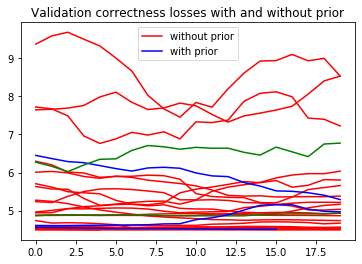

In [42]:
# Plot validation correctness losses with and without prior
noprior_val_corr_losses = {key : extract_metrics_values(m, "val_corr_losses") for key, m in noprior_metrics.items()}
prior_val_corr_losses = {key : extract_metrics_values(m, "val_corr_losses") for key, m in prior_metrics.items()}
plt.figure()
for key, corr_losses in noprior_val_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(corr_losses, axis=1)), 3)
    noprior_line, = plt.plot(line, color="red")
for key, corr_losses in prior_val_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(corr_losses, axis=1)), 3)
    prior_line, = plt.plot(line, color=("green" if key in ("1", "3") else "blue"))
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Validation correctness losses with and without prior")

Text(0.5, 1.0, 'Validation attribution losses with prior')

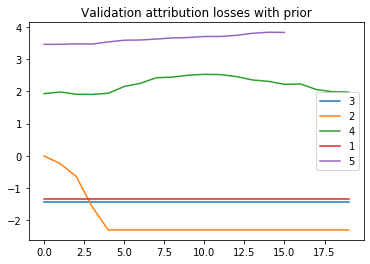

In [44]:
# Plot validation attribution losses with and without prior
prior_val_att_losses = {key : extract_metrics_values(m, "val_att_losses") for key, m in prior_metrics.items()}
plt.figure()
for key, att_losses in prior_val_att_losses.items():
    line = smooth_signal(np.log(np.nanmean(att_losses, axis=1)), 3)
    prior_line, = plt.plot(line, label=key)
plt.legend()
plt.title("Validation attribution losses with prior")

In [37]:
np.unique(prior_val_att_losses["3"])

array([0.23782232])

Text(0.5, 1.0, 'Validation batch losses with and without prior')

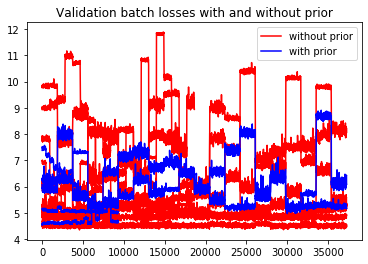

In [13]:
# Plot validation batch losses with and without prior
noprior_val_batch_losses = {key : extract_metrics_values(m, "val_batch_losses") for key, m in noprior_metrics.items()}
prior_val_batch_losses = {key : extract_metrics_values(m, "val_batch_losses") for key, m in prior_metrics.items()}
plt.figure()
for key, batch_losses in noprior_val_batch_losses.items():
    line = smooth_signal(np.log(np.concatenate(batch_losses)), 10)
    noprior_line, = plt.plot(line, color="red")
for key, batch_losses in prior_val_batch_losses.items():
    line = smooth_signal(np.log(np.concatenate(batch_losses)), 10)
    prior_line, = plt.plot(line, color="blue")
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Validation batch losses with and without prior")

Text(0.5, 1.0, 'Training correctness losses on noise with and without prior')

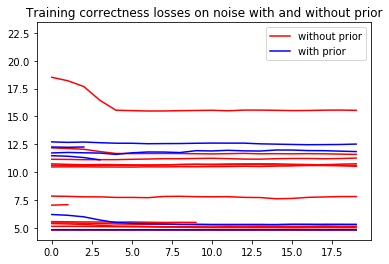

In [14]:
# Plot training correctness losses on noise with and without prior
noprior_noisy_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in noprior_noisy_metrics.items()}
prior_noisy_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in prior_noisy_metrics.items()}
plt.figure()
for key, corr_losses in noprior_noisy_train_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(corr_losses, axis=1)), 3)
    noprior_line, = plt.plot(line, color="red")
for key, corr_losses in prior_noisy_train_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(corr_losses, axis=1)), 3)
    prior_line, = plt.plot(line, color="blue")
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Training correctness losses on noise with and without prior")

Text(0.5, 1.0, 'Training correctness losses on noise with and without prior, first 100 batches of epoch 1')

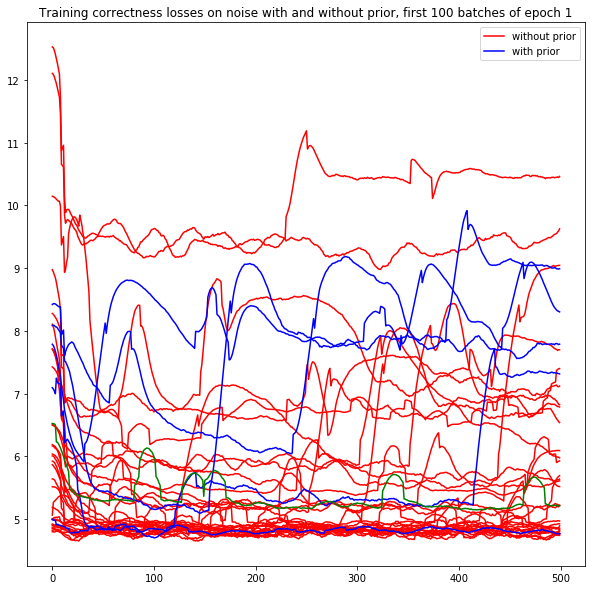

In [33]:
# Plot training correctness losses on noise with and without prior
noprior_noisy_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in noprior_noisy_metrics.items()}
prior_noisy_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in prior_noisy_metrics.items()}
plt.figure(figsize=(10, 10))
for key, corr_losses in noprior_noisy_train_corr_losses.items():
    line = smooth_signal(np.log(corr_losses[0][:500]), 10)
    noprior_line, = plt.plot(line, color="red")
for key, corr_losses in prior_noisy_train_corr_losses.items():
    line = smooth_signal(np.log(corr_losses[0][:500]), 10)
    prior_line, = plt.plot(line, color=("green" if key == "1" else "blue"))
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Training correctness losses on noise with and without prior, first 100 batches of epoch 1")

Text(0.5, 1.0, 'Training correctness losses with and without prior, first 100 batches of epoch 1')

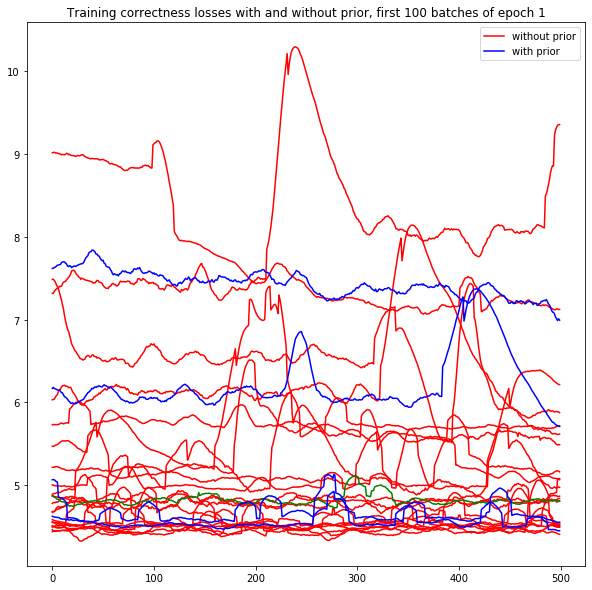

In [43]:
# Plot training correctness losses with and without prior
noprior_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in noprior_metrics.items()}
prior_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in prior_metrics.items()}
plt.figure(figsize=(10, 10))
for key, corr_losses in noprior_train_corr_losses.items():
    line = smooth_signal(np.log(corr_losses[2][:500]), 10)
    noprior_line, = plt.plot(line, color="red")
for key, corr_losses in prior_train_corr_losses.items():
    line = smooth_signal(np.log(corr_losses[2][:500]), 10)
    prior_line, = plt.plot(line, color=("green" if key == "3" else "blue"))
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Training correctness losses with and without prior, first 100 batches of epoch 1")

In [17]:
[(key, len(m)) for key, m in prior_val_corr_losses.items()]

[('3', 20), ('2', 20), ('4', 20), ('1', 20), ('5', 16)]

In [ ]:
# prior_val_epoch_losses["17"]
np.any(np.isnan(prior_val_corr_losses["17"]))
prior_val_att_losses["17"]

In [ ]:
for m in prior_val_att_losses.values():
    print(np.any(np.isnan(m)))